In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

In [2]:
dataset_path: str = './dataset/'
dataset_filename: str = 'data1.mat'
data = scipy.io.loadmat(os.path.join(dataset_path, dataset_filename))

In [3]:
train_X: np.ndarray = data['TrainingX']
train_Y: np.ndarray = data['TrainingY'].flatten()
test_X: np.ndarray = data['TestX']
test_Y: np.ndarray = data['TestY'].flatten()

In [4]:
def sigmoid(v: np.ndarray) -> np.ndarray:
    "The sigmoid function, applied to input v."
    return 1 / (1 + np.exp(-v))

def loss(w: np.ndarray, k: np.ndarray, y: np.ndarray, lamb: float) -> float:
    """
    The logistic loss function with L2 regularization. Computes for weight
    vector w on kernel input k with labels y and regularization parameter lamb.
    """
    return -np.sum(np.log(sigmoid(y * k.T.dot(w)))) + lamb * w.T.dot(w)

def gradient(w: np.ndarray, k: np.ndarray, y: np.ndarray, lamb: float) -> float:
    """
    The gradient of the logistic loss function with L2 regularization. Computes
    for weight vector w on kernel input k with labels y and regularization
    parameter lamb.
    """
    return -np.sum(y * (1 - sigmoid(y * k.T.dot(w) + 1e-10)) * k, axis=1) + 2 * lamb * w

In [5]:
def get_sigma_squared(X: np.ndarray) -> float:
    "Computes the sigma squared value for an input matrix X."
    pdst = squareform(pdist(X, metric='sqeuclidean'))
    return np.sum(pdst) / (X.shape[0] ** 2)

class Kernel:
    """
    Kernel function fit to an input X matrix and can be applied as a
    transform to a corresponding Y matrix.
    """
    def __init__(self, X: np.ndarray):
        var = get_sigma_squared(X)
        self.gamma = 1 / (2 * var)
        self.x = X
    
    def __call__(self, Y: np.ndarray) -> np.ndarray:
        return rbf_kernel(self.x, Y, self.gamma)

In [6]:
def get_train_test_kernels(
    train_X: np.ndarray,
    test_X: np.ndarray,
    subsample: bool = False,
    train_Y: np.ndarray = None,
    samples_per_class: int = 2000,
) -> np.ndarray:
    """
    Retrieves the train and test kernels, subsampling the original dataset if
    necessary.

    Parameters:
        train_X:            The training inputs
        test_X:             The test inputs
        subsample:          The number of samples to subsample per class
        train_Y:            The training targets for subsampling
        samples_per_class:  The number of samples in each class
    
    Returns:
        The kernels for the train and test sets
    """
    if subsample:
        assert train_Y is not None, \
            "Must provide train Y values for subsampling"
        one_indices: np.ndarray = np.arange(train_Y.shape[0])[train_Y == 1]
        neg_indices: np.ndarray = np.arange(train_Y.shape[0])[train_Y == -1]
        one_indices = np.random.permutation(one_indices)[:samples_per_class]
        neg_indices = np.random.permutation(neg_indices)[:samples_per_class]
        subset: np.ndarray = train_X[np.concatenate((one_indices, neg_indices))]
        kernel: Kernel = Kernel(subset)
        return kernel(train_X), kernel(test_X)

    kernel: Kernel = Kernel(train_X)
    return kernel(train_X), kernel(test_X)

In [7]:
def train(
    k: np.ndarray,
    y: np.ndarray,
    lamb: float,
    lr: float,
    opt: str,
    p: float = 1,
    maxcor: int = 10
) -> tuple[np.ndarray, pd.DataFrame]:
    """
    Trains a weight vector on the dataset k and y with regularization
    parameter lambda, learning rate lr, and optimizer opt.

    Parameters:
        k:      The input kernel for the logistic regressor
        y:      The targets for the logistic regressor
        lamb:   The lambda parameter
        lr:     The learning rate parameters
        opt:    The optimizer in string form
        p:      Batch size for SGD
        maxcor: The number of vectors to use for LBFGS
    
    Returns:
        The history of the training
    """
    epoch: int = 1
    history: pd.DataFrame = pd.DataFrame(columns=['Train Loss'])
    def iter_callback(w: np.ndarray):
        print(f"Epoch {iter_callback.iter}")
        train_loss: float = loss(w, k, y, lamb)
        print(f"Train Loss: {train_loss}")
        iter_callback.history.loc[len(iter_callback.history)] = train_loss
        iter_callback.iter += 1
    iter_callback.iter = 1
    iter_callback.history = pd.DataFrame(columns=['Train Loss'])
    w: np.ndarray = np.zeros(k.shape[0])

    if opt == "gd":
        while True:
            print(f"Epoch {epoch}")
            train_loss: float = loss(w, k, y, lamb)
            print(f"Train Loss: {train_loss}")
            history.loc[len(history)] = train_loss
            grad = gradient(w, k, y, lamb)
            w -= lr * grad
            if np.linalg.norm(grad) <= 1e-5:
                break
            epoch += 1
    elif opt == "sgd":
        old_loss: float = np.inf
        lr_decay: bool = False # decay only once loss changes start to slow
        while True:
            # Record train loss
            print(f"Epoch {epoch}")
            train_loss: float = loss(w, k, y, lamb)
            print(f"Train Loss: {train_loss}")
            history.loc[len(history)] = train_loss
            
            # Decide if we should start decaying LR
            loss_delta: float = np.abs(train_loss - old_loss)
            if loss_delta <= 0.001 or old_loss < train_loss:
                lr_decay = True
            old_loss = train_loss
            dyn_lr = lr / (epoch ** 3)

            rng: np.ndarray = np.random.permutation(np.arange(k.shape[0]))
            for batch in range(k.shape[0] // p):
                # Create batch
                batch_range: list[int] = [batch * p, (batch + 1) * p]
                batch_indices = rng[batch_range[0]:batch_range[1]]
                batch_K = k[:, batch_indices]
                batch_Y = y[batch_indices]

                # Split up weight decay across batches
                lamb_grad = lamb / (k.shape[0] / p)

                # Gradient update
                grad =  gradient(w, batch_K, batch_Y, lamb_grad)
                step = dyn_lr * grad if lr_decay else lr * grad
                w -= step

                # Decide if we should stop
                if np.linalg.norm(step) <= 1e-5:
                    end = True
                    break
                else:
                    end = False
            if end:
                break
            epoch += 1
    elif opt == "bfgs":
        w = minimize(
            fun=loss,
            x0=w,
            args=(k, y, lamb),
            method='BFGS',
            jac=gradient,
            callback=iter_callback,
        ).x
        history = iter_callback.history
    elif opt == "lbfgs":
        w = minimize(
            fun=loss,
            x0=w,
            args=(k, y, lamb),
            method='L-BFGS-B',
            jac=gradient,
            callback=iter_callback,
            options={
                'maxcor' : maxcor
            }
        ).x
        history = iter_callback.history
    return w, history

In [8]:
train_K_unscaled: np.ndarray; test_K_unscaled: np.ndarray
train_K: np.ndarray; test_K: np.ndarray
train_K_unscaled, test_K_unscaled = get_train_test_kernels(train_X, test_X)

In [9]:
# Rescaling helps values not blow up
train_K = train_K_unscaled / 6000
test_K = test_K_unscaled / 6000

In [11]:
bfgs_K_unscaled: np.ndarray; bfgs_test_K_unscaled: np.ndarray
bfgs_K: np.ndarray; bfgs_test_K: np.ndarray
bfgs_K_unscaled, bfgs_test_K_unscaled = get_train_test_kernels(
    train_X,
    test_X,
    subsample=True,
    train_Y=train_Y
)
bfgs_K = bfgs_K_unscaled / 6000
bfgs_test_K = bfgs_test_K_unscaled / 6000

In [12]:
lamb: float = 0.01

In [13]:
opt: str = "gd"
lr: float = 0.5
gd_w: np.ndarray; gd_history: pd.DataFrame
gd_w, gd_history = train(train_K, train_Y, lamb, lr, opt)

Epoch 1
Train Loss: 6931.471805599453
Epoch 2
Train Loss: 6929.249496199183
Epoch 3
Train Loss: 6927.169055370142
Epoch 4
Train Loss: 6925.202348329961
Epoch 5
Train Loss: 6923.328433919629
Epoch 6
Train Loss: 6921.531681545782
Epoch 7
Train Loss: 6919.800381826521
Epoch 8
Train Loss: 6918.1257215699725
Epoch 9
Train Loss: 6916.501027567725
Epoch 10
Train Loss: 6914.921208704513
Epoch 11
Train Loss: 6913.382344363787
Epoch 12
Train Loss: 6911.881380749755
Epoch 13
Train Loss: 6910.4159068135405
Epoch 14
Train Loss: 6908.983988898615
Epoch 15
Train Loss: 6907.584048700407
Epoch 16
Train Loss: 6906.214773176934
Epoch 17
Train Loss: 6904.87504802898
Epoch 18
Train Loss: 6903.563908567408
Epoch 19
Train Loss: 6902.28050340742
Epoch 20
Train Loss: 6901.02406762593
Epoch 21
Train Loss: 6899.793902900859
Epoch 22
Train Loss: 6898.589362801966
Epoch 23
Train Loss: 6897.409841883086
Epoch 24
Train Loss: 6896.254767579809
Epoch 25
Train Loss: 6895.123594177795
Epoch 26
Train Loss: 6894.015798309

In [14]:
opt: str = "sgd"
lr: float = 1
p: int = 100
sgd_100_w: np.ndarray; sgd_100_history: pd.DataFrame
sgd_100_w, sgd_100_history = train(train_K, train_Y, lamb, lr, opt, p)

Epoch 1
Train Loss: 6931.471805599453
Epoch 2
Train Loss: 6927.227267318698
Epoch 3
Train Loss: 6923.365962247177
Epoch 4
Train Loss: 6919.859257948226
Epoch 5
Train Loss: 6916.575555691646
Epoch 6
Train Loss: 6913.469467906016
Epoch 7
Train Loss: 6910.504554327614
Epoch 8
Train Loss: 6907.687334863922
Epoch 9
Train Loss: 6904.986488158478
Epoch 10
Train Loss: 6902.40427824877
Epoch 11
Train Loss: 6899.919776167033
Epoch 12
Train Loss: 6897.543378320982
Epoch 13
Train Loss: 6895.261582162569
Epoch 14
Train Loss: 6893.074284775699
Epoch 15
Train Loss: 6890.974397147163
Epoch 16
Train Loss: 6888.960760145568
Epoch 17
Train Loss: 6887.029030424567
Epoch 18
Train Loss: 6885.176492774661
Epoch 19
Train Loss: 6883.3986270994665
Epoch 20
Train Loss: 6881.692211351112
Epoch 21
Train Loss: 6880.0559401365645
Epoch 22
Train Loss: 6878.484976627482
Epoch 23
Train Loss: 6876.978599095684
Epoch 24
Train Loss: 6875.532682172061
Epoch 25
Train Loss: 6874.145915190982
Epoch 26
Train Loss: 6872.8151161

In [15]:
p: int = 1
sgd_1_w: np.ndarray; sgd_1_history: pd.DataFrame
sgd_1_w, sgd_1_history = train(train_K, train_Y, lamb, lr, opt, p)

Epoch 1
Train Loss: 6931.471805599453
Epoch 2
Train Loss: 6927.19792757019
Epoch 3
Train Loss: 6923.37300399484
Epoch 4
Train Loss: 6919.866486685332
Epoch 5
Train Loss: 6916.582239849215
Epoch 6
Train Loss: 6913.476181363428
Epoch 7
Train Loss: 6910.507028635557
Epoch 8
Train Loss: 6907.678288466176
Epoch 9
Train Loss: 6904.983155367272
Epoch 10
Train Loss: 6902.396967593785
Epoch 11
Train Loss: 6899.920791998916
Epoch 12
Train Loss: 6897.542754625151
Epoch 13
Train Loss: 6895.262489609098
Epoch 14
Train Loss: 6893.076928882649
Epoch 15
Train Loss: 6890.980110321318
Epoch 16
Train Loss: 6888.965186648916
Epoch 17
Train Loss: 6887.034324169301
Epoch 18
Train Loss: 6885.180151425725
Epoch 19
Train Loss: 6883.402020681152
Epoch 20
Train Loss: 6881.695971242311
Epoch 21
Train Loss: 6880.05918784102
Epoch 22
Train Loss: 6878.489201512184
Epoch 23
Train Loss: 6876.982298143215
Epoch 24
Train Loss: 6875.537140279836
Epoch 25
Train Loss: 6874.149556583999
Epoch 26
Train Loss: 6872.81891206751

In [16]:
opt = "bfgs"
bfgs_w: np.ndarray; bfgs_history: pd.DataFrame
bfgs_w, bfgs_history = train(bfgs_K, train_Y, lamb, lr, opt)

Epoch 1
Train Loss: 6925.151593853819
Epoch 2
Train Loss: 6914.61983207711
Epoch 3
Train Loss: 6905.215065798347
Epoch 4
Train Loss: 6903.504096967731
Epoch 5
Train Loss: 6900.396073281848
Epoch 6
Train Loss: 6895.613089416973
Epoch 7
Train Loss: 6893.620467388609
Epoch 8
Train Loss: 6893.591814930905
Epoch 9
Train Loss: 6893.587430211146
Epoch 10
Train Loss: 6893.587425045763
Epoch 11
Train Loss: 6893.587415452174
Epoch 12
Train Loss: 6893.587397904866
Epoch 13
Train Loss: 6893.587368023076
Epoch 14
Train Loss: 6893.587330061126
Epoch 15
Train Loss: 6893.587320617856
Epoch 16
Train Loss: 6893.587316412312


In [17]:
opt = "lbfgs"
lbfgs_w: np.ndarray; lbfgs_history: pd.DataFrame
lbfgs_w, lbfgs_history = train(train_K, train_Y, lamb, lr, opt, maxcor=100)

Epoch 1
Train Loss: 6921.71396657739
Epoch 2
Train Loss: 6863.651624172415
Epoch 3
Train Loss: 6841.330000466706
Epoch 4
Train Loss: 6841.328791541861
Epoch 5
Train Loss: 6841.327828432469
Epoch 6
Train Loss: 6841.327559005026
Epoch 7
Train Loss: 6841.327537237943


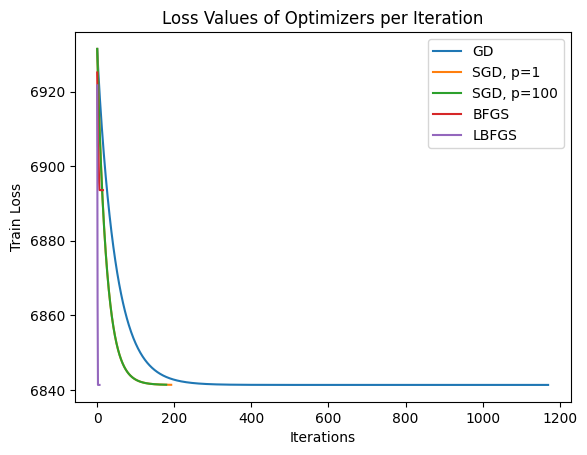

In [21]:
plt.plot(gd_history.index, gd_history['Train Loss'], label="GD")
plt.plot(sgd_1_history.index, sgd_1_history['Train Loss'], label="SGD, p=1")
plt.plot(sgd_100_history.index, sgd_100_history['Train Loss'], label="SGD, p=100")
plt.plot(bfgs_history.index, bfgs_history['Train Loss'], label="BFGS")
plt.plot(lbfgs_history.index, lbfgs_history['Train Loss'], label="LBFGS")
plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.title("Loss Values of Optimizers per Iteration")
plt.legend()
plt.show()

In [19]:
def accuracy(w: np.ndarray, k: np.ndarray, y: np.ndarray) -> float:
    "Gets the accuracy of the weight vector w on kernel k with targets y."
    p: np.ndarray = sigmoid(k.T.dot(w))
    y_pred: np.ndarray = (p >= 0.5).astype(int) * 2 - 1
    return np.mean(y_pred == y)

In [20]:
print(f'GD Train Accuracy: {accuracy(gd_w, train_K, train_Y) * 100:.2f}%')
print(f'GD Test Accuracy: {accuracy(gd_w, test_K, test_Y) * 100:.2f}%')
print(f'SGD Train Accuracy, p=1: {accuracy(sgd_1_w, train_K, train_Y) * 100:.2f}%')
print(f'SGD Test Accuracy, p=1: {accuracy(sgd_1_w, test_K, test_Y) * 100:.2f}%')
print(f'SGD Train Accuracy, p=100: {accuracy(sgd_100_w, train_K, train_Y) * 100:.2f}%')
print(f'SGD Test Accuracy, p=100: {accuracy(sgd_100_w, test_K, test_Y) * 100:.2f}%')
print(f'BFGS Train Accuracy: {accuracy(bfgs_w, bfgs_K, train_Y) * 100:.2f}%')
print(f'BFGS Test Accuracy: {accuracy(bfgs_w, bfgs_test_K, test_Y) * 100:.2f}%')
print(f'LBFGS Train Accuracy: {accuracy(lbfgs_w, train_K, train_Y) * 100:.2f}%')
print(f'LBFGS Test Accuracy: {accuracy(lbfgs_w, test_K, test_Y) * 100:.2f}%')

GD Train Accuracy: 78.91%
GD Test Accuracy: 81.40%
SGD Train Accuracy, p=1: 78.96%
SGD Test Accuracy, p=1: 81.50%
SGD Train Accuracy, p=100: 78.97%
SGD Test Accuracy, p=100: 81.50%
BFGS Train Accuracy: 54.50%
BFGS Test Accuracy: 54.50%
LBFGS Train Accuracy: 78.91%
LBFGS Test Accuracy: 81.40%
